# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
import warnings


In [2]:
df = pd.read_csv('/datasets/Churn.csv')
display(df.head())
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Данные предобработаны, есть немного пропусков в колонке Tenure, но в целом готовы для работы

## Исследование задачи

### Предобработка 

In [3]:
df.duplicated().sum()

0

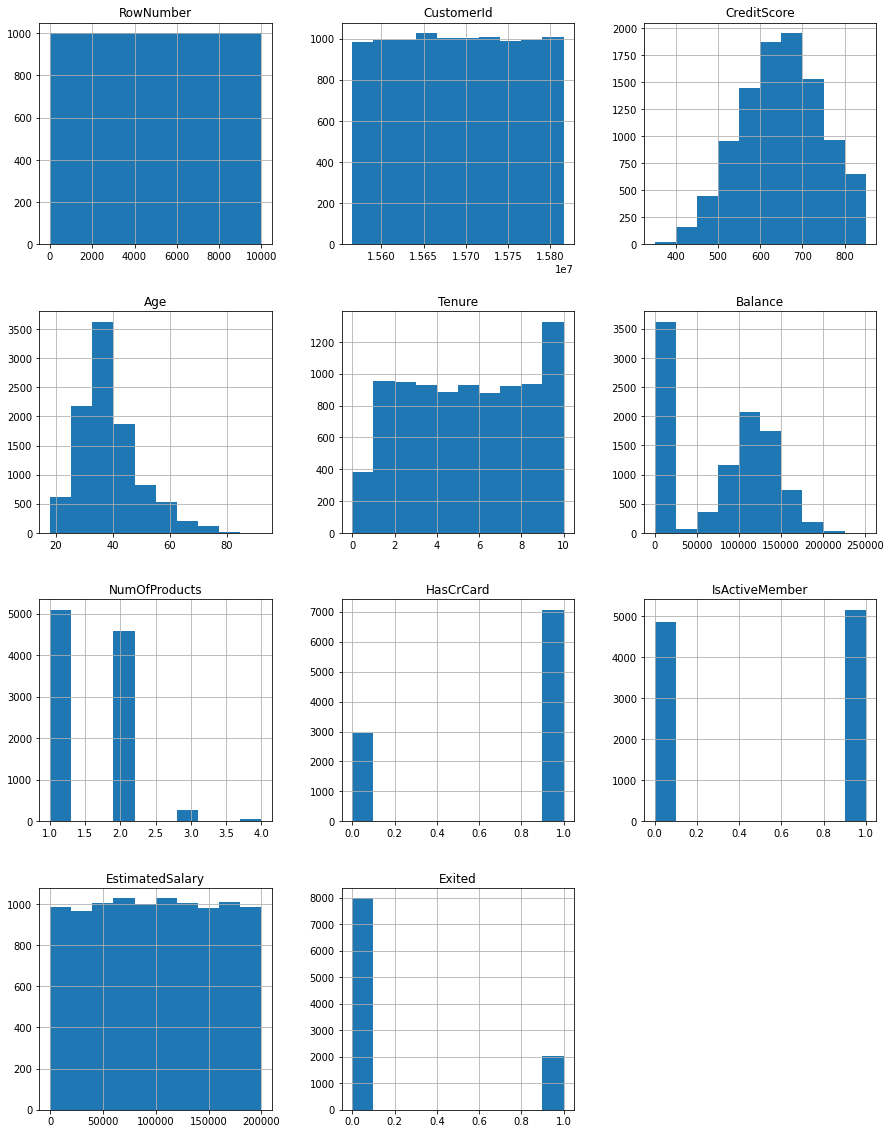

In [4]:
df.hist(figsize=(15, 20))
plt.show()

Дупликатов не наблюдается, есть немного пропусков в колонке 'Tenure', но не критично, аномалии отсутствуют, разве что за исключением большого числа аккаунтов с нулевым балансом

In [6]:
df.dropna(subset=['Tenure'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


In [7]:
df = df.drop(['CustomerId', 'RowNumber', 'Surname'], axis=1)
df = pd.get_dummies(df, drop_first=True, columns=['Geography', 'Gender', 'Tenure', 'NumOfProducts'])

уберем некоторые колонки, которые не пригодятся для обучения модели и только помешают, также приведем таблицу к формату OHE для категориальных данных

In [8]:
display(df.head())
df.info()
print('\n \nvalue counts of exited:')
print(df['Exited'].value_counts())
print('\ndisbalance of classes:')
df['Exited'].mean()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,...,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,619,42,0.00,1,1,101348.88,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,608,41,83807.86,0,1,112542.58,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,502,42,159660.80,1,0,113931.57,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,699,39,0.00,0,0,93826.63,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,850,43,125510.82,1,1,79084.10,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9091 non-null   int64  
 1   Age                9091 non-null   int64  
 2   Balance            9091 non-null   float64
 3   HasCrCard          9091 non-null   int64  
 4   IsActiveMember     9091 non-null   int64  
 5   EstimatedSalary    9091 non-null   float64
 6   Exited             9091 non-null   int64  
 7   Geography_Germany  9091 non-null   uint8  
 8   Geography_Spain    9091 non-null   uint8  
 9   Gender_Male        9091 non-null   uint8  
 10  Tenure_1.0         9091 non-null   uint8  
 11  Tenure_2.0         9091 non-null   uint8  
 12  Tenure_3.0         9091 non-null   uint8  
 13  Tenure_4.0         9091 non-null   uint8  
 14  Tenure_5.0         9091 non-null   uint8  
 15  Tenure_6.0         9091 non-null   uint8  
 16  Tenure_7.0         9091 

0.2039379606203938

имеется дисбаланс классов, колонки 'Balance', 'EstimatedSalary' номинально сильно больше чем 'CreditScore', 'age'

In [40]:
features = df.drop(['Exited'], axis=1)
target = df['Exited']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=12345)

print('number of rows in features_train', len(features_train))
print(
    'number of rows in features_test', len(features_valid),
    '\nif the latter is 3 times smaller the division is done correctly'
)

number of rows in features_train 5454
number of rows in features_test 1819 
if the latter is 3 times smaller the division is done correctly


In [10]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [11]:
warnings.filterwarnings('ignore')

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
print(features_valid.shape)

(5454, 22)
(1819, 22)


In [12]:
features_train.head()

,CreditScore,Age,Balance,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Tenure_1.0,...,Tenure_4.0,Tenure_5.0,Tenure_6.0,Tenure_7.0,Tenure_8.0,Tenure_9.0,Tenure_10.0,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
9344,0.809075,-1.039327,0.554904,1,0,0.019508,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3796,-1.152518,-1.227561,0.480609,0,0,0.056167,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
7462,-0.398853,0.090079,-1.237830,1,1,0.848738,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1508,-0.749875,-0.286389,-1.237830,1,1,-0.894953,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4478,-1.028628,-0.756975,-1.237830,0,1,-1.284516,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0


### Моделирование до балансировки

In [13]:
model_log = LogisticRegression(random_state=12345)
model_log.fit(features_train, target_train)
predictions = model_log.predict(features_valid)
result = f1_score(target_valid, predictions)
recall = recall_score(target_valid, predictions)
print("f1 наилучшей модели LOG REG на валидационной выборке:", result, 'recall:', recall)


f1 наилучшей модели LOG REG на валидационной выборке: 0.4734848484848485 recall: 0.3561253561253561


In [14]:
best_model = None
best_result = 0
best_depth = 0
best_recall = recall_score(target_valid, predictions)
for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    recall = recall_score(target_valid, predictions)
    if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result 
            recall = recall_score(target_valid, predictions)
print(
    "f1 наилучшей модели TREE CLASS на валидационной выборке:", best_result, 'best recall:', best_recall, 'depth:', best_depth
)

f1 наилучшей модели TREE CLASS на валидационной выборке: 0.5411764705882351 best recall: 0.3561253561253561 depth: 2


In [16]:
best_model = None
best_result = 0
best_depth = 0
best_est = 0
best_recall = recall_score(target_valid, predictions)

for est in [15, 30, 60, 100, 200]:
    for depth in [6, 14, 20, 25]:
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
        
        if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result
            best_est = est
            best_recall = recall
            
print('best_result', best_result)
print('best_depth', best_depth)
print('best_est', best_est)
print('best_recall', best_recall)

best_result 0.5642857142857142
best_depth 14
best_est 15
best_recall 0.45014245014245013


по итогу наилучший показатель f1 до балансировки был у модели RandomForestClassifier с показателем около 0.55

In [17]:
best_model = RandomForestClassifier(random_state=12345, max_depth=20, n_estimators=30)
best_model.fit(features_train, target_train)

RandomForestClassifier(max_depth=20, n_estimators=30, random_state=12345)

In [18]:
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [19]:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8462460311915353

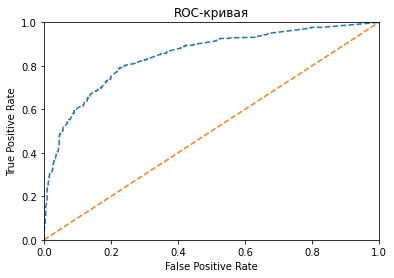

In [20]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()

plt.plot(fpr, tpr, linestyle='--')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

При работе с данными без балансировки наилучшими гиперпараметрами являются max_depth=20 и n_estimators=100

## Борьба с дисбалансом

In [21]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.mean()

0.509963768115942

In [22]:
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model_log.fit(features_upsampled, target_upsampled)
predicted_valid = model_log.predict(features_valid)
best_recall = recall_score(target_valid, predictions)

print("F1 of LOGISTIC REGRESSION UPsampled:", f1_score(target_valid, predicted_valid), 'recall', best_recall)

F1 of LOGISTIC REGRESSION UPsampled: 0.558091286307054 recall 0.4358974358974359


In [23]:
best_model = None
best_result = 0
best_depth = 0
best_recall = recall_score(target_valid, predictions)

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    recall = recall_score(target_valid, predictions)
    
    if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result
            recall = recall
            
print("f1 наилучшей модели TREE CLASS UPsampled:", best_result, 'best_recall', best_recall, 'depth:', best_depth)

f1 наилучшей модели TREE CLASS UPsampled: 0.5608108108108109 best_recall 0.4358974358974359 depth: 4


In [24]:
best_model = None
best_result = 0
best_depth = 0
best_est = 0
best_recall = recall_score(target_valid, predictions)

for est in [10, 20, 30, 60, 100, 200]:
    for depth in [3, 6, 14, 20, 25]:
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
        
        if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result
            best_est = est
            best_recall = recall
            
print('best_result of FOREST after UPsampling', best_result)
print('best_depth', best_depth)
print('best_est', best_est)
print('best_recall', best_recall)

best_result of FOREST after UPsampling 0.6163328197226502
best_depth 25
best_est 200
best_recall 0.5698005698005698


после балансирования данных и апскейлинга лучшими параметрами являются max_depth=14 и n_estimators=60

In [25]:
pred_valid = best_model.predict(features_valid)
f1 = f1_score(target_valid, pred_valid)
f1

0.6163328197226502

In [26]:
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8550860911215133

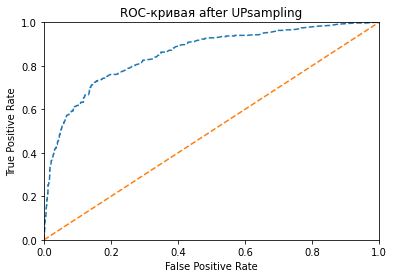

In [27]:
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) # < напишите код здесь >

plt.figure()
plt.plot(fpr, tpr, linestyle='--')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая after UPsampling')

plt.show()

#### DOWNSAMPLING

In [28]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)
print('new mean of classes after DOWNsampling')
target_downsampled.mean()

new mean of classes after DOWNsampling


0.509963768115942

In [29]:
model_log = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
best_recall = recall_score(target_valid, predictions)

print("F1 of LOGISTIC REGRESSION DOWNsampled:", f1_score(target_valid, predicted_valid), 'best_recall', best_recall)

F1 of LOGISTIC REGRESSION DOWNsampled: 0.5613682092555332 best_recall 0.5698005698005698


In [30]:
best_model = None
best_result = 0
best_depth = 0
best_recall = recall_score(target_valid, predictions)

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    recall = recall_score(target_valid, predictions)
    
    if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result
            best_recall = recall
            
            
print("f1 наилучшей модели TREE CLASS DOWNsampled:", best_result, 'best_recall', best_recall, 'depth:', best_depth)

f1 наилучшей модели TREE CLASS DOWNsampled: 0.5387673956262425 best_recall 0.7720797720797721 depth: 6


In [31]:
best_model = None
best_result = 0
best_depth = 0
best_est = 0
best_recall = recall_score(target_valid, predictions)

for est in [5, 10, 20, 30, 60, 100, 200]:
    for depth in [3, 6, 14, 20, 25]:
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
        
        if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result
            best_est = est
            best_recall = recall
            
print('best_result of FOREST DOWNsampled', best_result)
print('best_depth', best_depth)
print('best_est', best_est)
print('best_recall', best_recall)

best_result of FOREST DOWNsampled 0.5708502024291499
best_depth 20
best_est 60
best_recall 0.8034188034188035


In [32]:
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8506214241909065

### взвешивание классов

In [33]:
model_log = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
best_recall = recall_score(target_valid, predictions)

print("F1 of LOGISTIC REGRESSION BALANCED WEIGHT:", f1_score(target_valid, predicted_valid), 'best_recall', best_recall)

F1 of LOGISTIC REGRESSION BALANCED WEIGHT: 0.5483870967741935 best_recall 0.7948717948717948


In [34]:
best_model = None
best_result = 0
best_depth = 0
best_recall = recall_score(target_valid, predictions)

for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    recall = recall_score(target_valid, predictions)
    
    if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result
            best_recall = recall
            
            
print("f1 наилучшей модели TREE CLASS BALANCED WEIGHT:", best_result, 'best_recall', best_recall, 'depth:', best_depth)

f1 наилучшей модели TREE CLASS BALANCED WEIGHT: 0.5608108108108109 best_recall 0.7094017094017094 depth: 4


In [35]:
best_model = None
best_result = 0
best_depth = 0
best_est = 0
best_recall = recall_score(target_valid, predictions)

for est in [5, 10, 20, 30, 60, 100, 200]:
    for depth in [3, 6, 14, 20, 25]:
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        recall = recall_score(target_valid, predictions)
        
        if result > best_result:
            best_depth = depth
            best_model = model 
            best_result = result
            best_est = est
            best_recall = recall
            
print('best_result of FOREST BALANCED WEIGHT', best_result)
print('best_recall', best_recall)
print('best_depth', best_depth)
print('best_est', best_est)


best_result of FOREST BALANCED WEIGHT 0.6127527216174184
best_recall 0.5612535612535613
best_depth 14
best_est 100


In [36]:
probabilities_valid = best_model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
auc_roc

0.8603445197450648

## Краткий вывод:  
Наилучшей моделью по f1 метрике оказалась модель RandomForestClassifier с данными после Upsampling, auc_roc после балансировки классов особо не изменился

## Тестирование модели

In [37]:
pred_test = best_model.predict(features_test)
f1 = f1_score(target_test, pred_test)
f1

0.6264367816091955

In [38]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(features_train, target_train)
f1 = f1_score(dummy_model.predict(features_test), target_test)
print('f1 of dummy model:', f1)

f1 of dummy model: 0.34350797266514804


## Выводы
лучшей моделью оказалась RandomForestClassifier после апсампглинга, почти в 2 раза лучше, чем dummy модель, с показателем f1 ~0.63, auc_roc не изменился c показателем в 0.85